In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import numpy as np
import IPython.display as display
import PIL.Image

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## Modelo de Rede Neural Convolucional (CNN):
As camadas Conv2D são camadas de convolução. Cada neurônio da camada convolucional não está conectado com todos os neurônios da camada anterior, mas apenas uma parte deles, aqueles que estiverem em seu "campo receptivo". Isso permite que a arquitetura se concentre em features mais simples nas primeiras camadas, e depois organize elas em formas mais complexas nas camadas mais profundas.

As Pooling layers servem para diminuir o tamanho da imagem, para reduzir o processamento, a memória requerida, e o número de parâmetros totais.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same', input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=110,
                     validation_data=(x_valid, y_valid),
                     callbacks=[early_stopping, lr_scheduler])

# Deep Dream:

Primeiro, carregamos a imagem que queremos processar através da rede neural:

In [9]:
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg/800px-Tabby_cat_with_blue_eyes-3336579.jpg'

In [10]:
# Download de uma imagem e ler ela como numpy array:
def download(url, max_dim=None):
    name = url.split('/')[-1] # O nome da imagem é o texto a partir do último /
    image_path = keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

# Normalizar a imagem:
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)

# Exibir a imagem:
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))

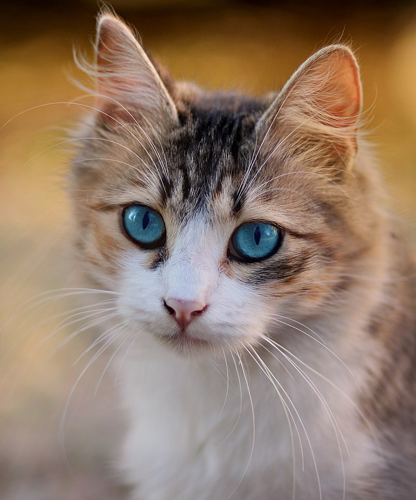

In [11]:
# Diminuir a imagem para que seja mais fácil trabalhar com ela:
gatinho = download(url, max_dim=500)
show(gatinho)

Ao invés de criar o modelo manualmente, podemos usar um modelo já criado e treinado. A rede neural InceptionV3 é parecida com aquela usada originalmente no DeepDream, então pode ser uma boa ideia começar por ela:

In [12]:
base_model = keras.applications.InceptionV3(include_top=False, weights='imagenet')

Quando vamos processar uma imagem, temos que tentar ajustar os parâmetros da melhor forma possível, através do "loss". O "loss" nos diz a diferença entre o valor esperado e o resultado produzido pela nossa rede neural. Normalmente, para obter previsões com a maior precisão possível, tentaríamos minimizar o "loss" o máximo possível.

Mas aí vem o plot-twist: Para que as features sejam excitadas nas camadas, ao invés de minimizar o "loss" via Gradient Descent, vamos maximizá-lo via Gradient Asecent!

A ideia do DeepDream é que, dentre as diferentes camadas de atributos (feature layers), possamos escolher algumas (isto é, escolhemos alguns features da imagem) e maximizar o "loss", de modo que essas camadas sejam acentuadas (e assim essas features apareçam de forma exagerada na imagem).

A complexidade dessas features é escolhida por nós: Ao escolher as primeiras camadas, excitamos padrões mais simples. Em contrapartida, selecionando camadas mais profundas, as features que aparecem são mais sofisticadas. Isso acontece pois, em DNNs, as primeiras camadas identificam formas mais básicas que compõem as imagem, como linhas, segmentos de curvas, quinas... Enquanto as camadas posteriores oganizam essas partes mais simples em objetos mais complexos, como formas geométricas, ou até rostos e objetos completos.

A arquitetura do InceptionV3 tem 11 camadas de concatenação, que agrupam camadas de convolução anteriores em uma só, e são nomeadas 'mixed0' até 'mixed10'. Para lidar com DeepDream, estamos interessados nessas camadas em específico. Como dito anteriormente, as primeiras concatenações resultam em linhas, formatos e texturas mais simples, enquanto as mais profundas, olhos e até rostos. Entretanto, camadas mais avançadas levam mais tempo para treinar.

In [34]:
# Maximizar a ativação das camadas que escolhermos:
names = ['mixed0', 'mixed1']
layers = [base_model.get_layer(name).output for name in names]

# Criar o modelo de extração de features:
dream_model = keras.Model(inputs=base_model.input, outputs=layers) # Os inputs são os mesmos do base_model, os outputs são as camadas que queremos

Agora, calculamos o loss das camadas escolhidas:

In [35]:
def calc_loss(img, model):
    # Passa a img pelo modelo para recuperar as ativações e converte a imagem num batch de tamanho 1
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
        
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)
        
    return tf.reduce_sum(losses)

Agora que temos o loss, basta calcular os gradientes com relação a imagem escolhida e adicionar esses gradientes à imagem original. Adicionar esses gradientes acentua os padrões vistos pela network: A cada step, criamos uma imagem que progressivamente excita as ativações dessas camadas na network.

O método para fazer isso está empacotado nessa tf.function, e usamos uma input_signature para assegurar que a função não é reutilizada para diferentes tamanhos da imagem, ou para valores diferentes de steps / step_size:

In [36]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model
        
    @tf.function(
        input_signature = (
             tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
            tf.TensorSpec(shape=[], dtype=tf.int32),
            tf.TensorSpec(shape=[], dtype=tf.float32)
        )
    )
    
    def __call__(self, img, steps, step_size):
        print('Tracing...')
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img) # GradientTape traça os gradientes calculados para img
                loss = calc_loss(img, self.model) # Calcula o loss com os gradientes que foram traçados
                
            # Agora, com o loss calculado, estimamos o gradiente do loss em relação aos pixels da imagem fornecida:
            gradients = tape.gradient(loss, img)
        
            # Normaliza os gradientes:
            gradients /= tf.math.reduce_std(gradients) + 1e-8
        
            # Agora, maximizamos o loss com o tempo. Podemos atualizar a imagem adicionando os gradientes diretamente
            # na imagem, pois eles tem o mesmo formato! :D
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1) # Define os valores mínimo e máximo que img pode assumir
        
        return loss, img

In [37]:
deepdream = DeepDream(dream_model)

In [38]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
    # Converte a imagem de uint8 para o formato esperado pelo modelo:
    img = keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img) # Converte o np.array para o formato esperado pelo tensorflow (um tensor)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        
        loss, img = deepdream(img, run_steps, tf.constant(step_size))
        
        display.clear_output(wait=True)
        show(deprocess(img))
        print('Step {}, loss {}'.format(step, loss))
        
    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)
    
    return result

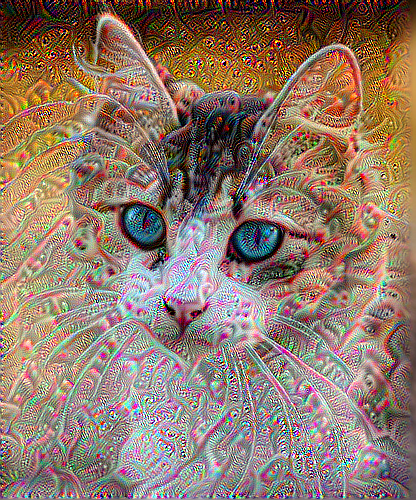

In [39]:
dream_img = run_deep_dream_simple(img=doguinho, steps=200, step_size=0.01)

Esta primeira tentativa ficou legal, mas a imagem tem baixa resolução e os padrões parecem ter certa granularidade. Podemos aplicar o Gradient Ascent em escalas diferentes, permitindo que os padrões sejam gerados em várias escalas diferentes, e assim se encaixem melhor, sem perda de continuidade.

Assim, vamos fazer o processo anterior, mas variando o tamanho da imagem (o que se chama uma OCTAVE), e repetir esse processo para várias octaves:

In [40]:
import time

def octave(img, scale=1.30, ranges=3, steps=50, step_size=0.01):
    start = time.time()

    OCTAVE_SCALE = scale

    img = tf.constant(np.array(img))
    base_shape = tf.shape(img)[:-1]
    float_base_shape = tf.cast(base_shape, tf.float32)

    for n in range(-ranges, +ranges):
        new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE ** n), tf.int32)
    
        img = tf.image.resize(img, new_shape).numpy()
    
        img = run_deep_dream_simple(img=img, steps=steps, step_size=step_size)
    
    display.clear_output(wait=True)
    img = tf.image.resize(img, base_shape)
    img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
    show(img)

    end = time.time()
    end-start

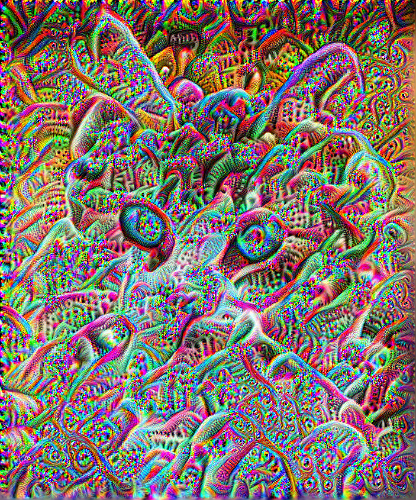

In [41]:
octave(img=doguinho, steps=200)

# Neural Style Transfer (Transferência Neural de Estilo):

É uma técnica de otimização na qual duas imagens (uma imagem de conteúdo e uma de referência) são misturadas, de modo que a imagem gerada parece a imagem de conteúdo, pintada no estilo da imagem de referência.

This is implemented by optimizing the output image so that the content statistics of the content image and the style statistics of the style image are matched. These statistics are extracted from them through a CNN.

In [66]:
import tensorflow as tf
from tensorflow import keras
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import functools
import time

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [67]:
def tensor_to_image(tensor): #deprocess and show(img)?
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [81]:
content_path = tf.keras.utils.get_file('Tabby_cat_with_blue_eyes-3336579.jpg', 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg/800px-Tabby_cat_with_blue_eyes-3336579.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [ ]:
url2 = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c7/Tabby_cat_with_blue_eyes-3336579.jpg/800px-Tabby_cat_with_blue_eyes-3336579.jpg'
url3 = 'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg'

In [82]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

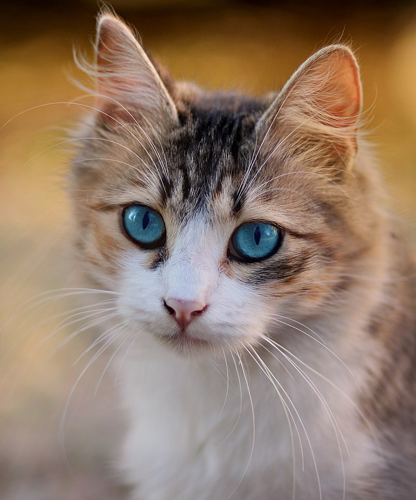

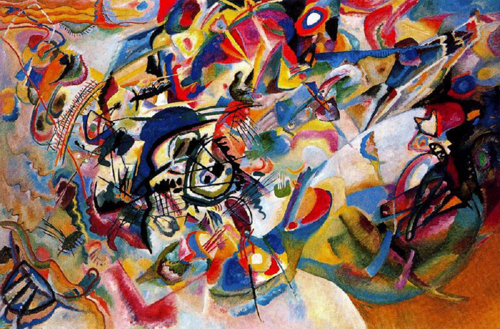

In [95]:
content_image = load_img(content_path)
style_image = load_img(style_path)

img2 = download(url2, max_dim=500)
img3 = download(url3, max_dim=500)

show(img2)
show(img3)

Agora, escolhemos camadas intermediárias da network para representar o estilo e o conteúdo da imagem:

In [85]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

Mas por que os resultados (outputs) contidos na network de classificação de imagens pré-treinada nos permitem definir representações de estilo e conteúdo?

Para que a network classifique a imagem, ela tem que entendê-la, o que exige pegar os pixels da imagem e construir uma representação que usa esses pixels para entender as features da imagem. É por isso que CNNs conseguem generalizar bem, elas capturam as invariâncias e features principais em classes. Assim, em algum lugar entre a entrada da imagem no modelo e a saída da classificação, o modelo funciona como uma complexo extrator de features. Ao acessar essas camadas intermediárias, podemos descrever o conteúdo e estilo das imagens.

In [86]:
def vgg_layers(layer_names):
    vgg_model = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg_model.trainable = False
    
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    
    transfer_model = keras.Model(inputs=vgg_model.input, outputs=outputs)
    return transfer_model

In [87]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image * 255)

In [88]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [89]:
#Now, building a model that returns the style and content tensors:
class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg_model = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg_model.trainable = False
        
    def call(self, inputs): #Expects float inputs in [0, 1] range
        inputs = inputs * 255.0
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg_model(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], outputs[self.num_style_layers:])
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        
        return {'content': content_dict, 'style': style_dict}

In [90]:
#When called upon an image, this model returns the gram_matrix (style) of the style_layers and content of the content_layers:
extractor = StyleContentModel(style_layers, content_layers)

results = tf.constant(content_image)

In [91]:
#With the style and content extractors, we can implement the style transfer algorithm by the mean
#square error for the image output relative to each target, then taking the weighted sum of these
#losses:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

#Defining a tf.Variable to contain the image to be optimized
image = tf.Variable(content_image)

#To normalize the pixel values between 0 and 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

#Adam optimizer
Adam = keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e-4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [92]:
#tf.GradientTape() to update the image
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    gradients = tape.gradient(loss, image)
    Adam.apply_gradients([(gradients, image)])
    image.assign(clip_0_1(image))

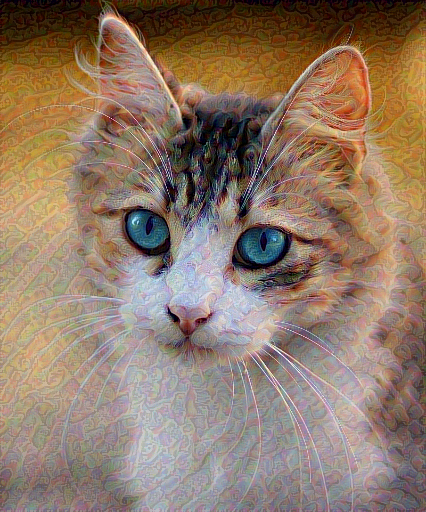

In [93]:
train_step(image)
train_step(image)
train_step(image)

tensor_to_image(image)

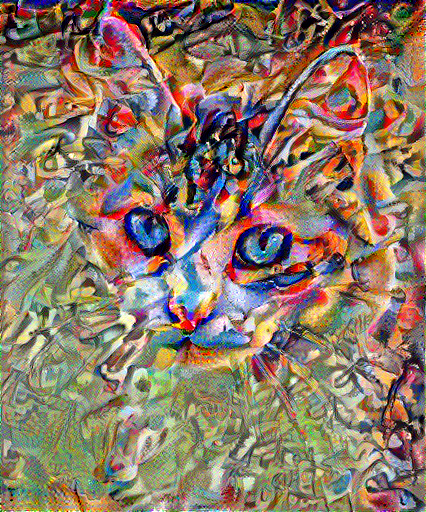

Train step: 1000
Total time: 1707.9


In [94]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))